In [1]:
import os
import scipy.io as sio
# 切换到包含文件的目录
os.chdir('/Users/gengxingri/Desktop/Leetcodes/HUAWEI')

from decimal import Decimal
import numpy as np

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh, norm, spsolve, cg, minres
import scipy.sparse as sp
import scipy.sparse.linalg as sla

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import time

In [2]:
# 读取.mat 文件
data = sio.loadmat('af_shell8.mat')
#data = sio.loadmat('sts4098.mat')

A = data['Problem']['A'][0][0]
print(A.shape, type(A))

b = data['Problem']['b'][0][0]
print(b.shape, type(b))


(504855, 504855) <class 'scipy.sparse._csc.csc_matrix'>
(504855, 1) <class 'numpy.ndarray'>


In [3]:
'''
tol 的值可以优化来提高eigval_min 的精度，但是算法的时间会增加
'''

# Calculate the condition number
start_time = time.time()

# return eigenvalues that have the min and max abs values, respectively
eigval_max = eigsh(A, k=1, which='LM', return_eigenvectors=False)[0]
eigval_min = eigsh(A, k=1, which='SM', return_eigenvectors=False, tol=1)[0]
print(eigval_min, eigval_max)

condition_number = eigval_max / eigval_min

print("Condition number based on eigenvalues:", condition_number)

end_time = time.time()
execution_time = end_time - start_time

print(f"Runing time：{execution_time} s")

6.461083536714519 3336183.6096447487
Condition number based on eigenvalues: 516350.4837365418
Runing time：328.6351320743561 s


In [4]:
# Create the diagonal preconditioner
n = A.shape[0]
diag_A = A.diagonal()

D = csc_matrix((1 / np.sqrt(diag_A), (np.arange(n), np.arange(n))), shape=(n, n))

# Apply preconditioning
A_new = D.dot(A.dot(D))

# 将 numpy 数组转换为 CSC 格式的稀疏矩阵
b_sparse = csc_matrix(b)

b_new = D.dot(b_sparse) / norm(D.dot(b_sparse)) 

print(A_new.diagonal(), norm(b_new))

[1. 1. 1. ... 1. 1. 1.] 1.0


In [5]:
# Calculate the condition number

eigval_max = eigsh(A_new, k=1, which='LM', return_eigenvectors=False)[0]
eigval_min = eigsh(A_new, k=1, which='SM', return_eigenvectors=False, tol=1)[0]
print(eigval_min, eigval_max)

condition_number = eigval_max / eigval_min

print("Condition number based on eigenvalues:", condition_number)


1.4116767587432543e-05 3.73724129420628
Condition number based on eigenvalues: 264737.7504134417


In [6]:
# Unique solution of Ax = b

x_unique = spsolve(A_new, b_new)
print(x_unique)

[ 2.33596524e-05  1.81894253e-05 -9.42954189e-09 ...  9.63890968e-07
 -1.51665524e-06  5.25518056e-06]


In [7]:
# CG mtheod
def conjugate_gradient_sparse(A, b, tol=1e-8, max_iter=5*b.shape[0]):
    n = b.shape[0] 
    x = np.zeros(n).reshape((n,1))
    r = b - A @ x
    #print(r.shape, type(r))
    xk_cg =[]
    
    
    p = r.copy()
    r_norm_sq = np.dot(r.T,r)
    errors = []  # Initial error
    #print(x.shape, r_norm_sq.shape)

    for i in range(max_iter):
        Ap = A @ p
        alpha = r_norm_sq / np.dot(p.T, Ap)
        x = x + alpha * p
        r -= alpha * Ap
        
        r_norm_sq_new = np.dot(r.T, r)
        
        #print(r_norm_sq_new.shape)
        errors.append(np.sqrt(r_norm_sq_new))  # Append new error
        xk_cg.append(x)
        if np.sqrt(r_norm_sq_new) < tol:
            print(f"Converged after {i+1} iterations")
            return x, errors, xk_cg
        
        beta = r_norm_sq_new / r_norm_sq
        p = r + beta * p
        r_norm_sq = r_norm_sq_new
    
    print(f"Did not converge after {max_iter} iterations")
    return x, errors, xk_cg

# Solve using our CG implementation
start_time = time.time()

b_array = b_new.toarray()
x_cg, errors, xk = conjugate_gradient_sparse(A_new, b_array)

cg_time = time.time() - start_time

print(f"CG method took {cg_time:.4f} seconds")

# change the type of errors_cg and xk_cg
errors_cg = [arr[0][0] for arr in errors]
xk_cg = [np.reshape(arr,-1) for arr in xk]

Converged after 1239 iterations
CG method took 49.0669 seconds


In [8]:
# MINRES method

errors_minres = []

xk_minres = []

def callback(xk):
    rk = b_array - A_new.dot(xk).reshape(-1,1)
    error_norm = np.linalg.norm(rk)
    errors_minres.append(error_norm)
    xk_minres.append(xk)
    return np.linalg.norm(rk)

x_minres, info_minres = minres(A_new, b_array, tol=0.5*1e-11, callback=callback)
print(x_minres, info_minres)
print('\n',errors_minres[0:5])

[ 2.32614069e-05  1.79431475e-05 -9.39774874e-09 ...  9.64215006e-07
 -1.06422646e-06  5.61766894e-06] 0

 [0.3492531138095971, 0.26803068989797196, 0.1315091518417673, 0.08641414645328896, 0.07016203885881234]


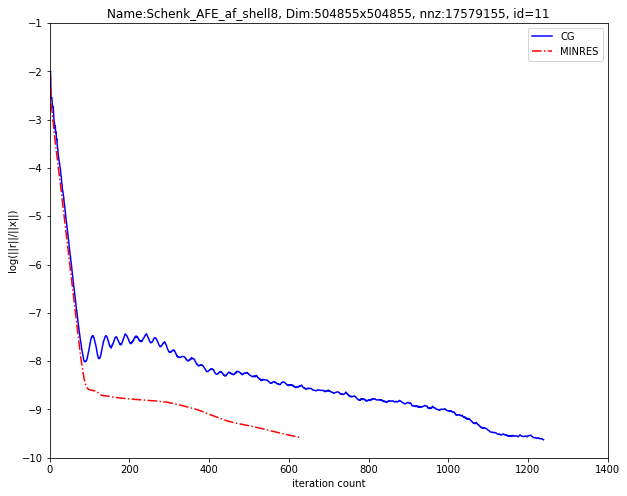

In [9]:
# Plot the log(||r||/||x||) errors

xk_cg_norms =  np.array([np.linalg.norm(xk) for xk in xk_cg])
xk_minres_norms =  np.array([np.linalg.norm(xk) for xk in xk_minres])

cg_errors = np.log10(errors_cg / xk_cg_norms) 
minres_errors = np.log10(errors_minres / xk_minres_norms)

def plot_log(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1,len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1,len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.set_ylabel('log(||r||/||x||)')
    ax.set_title('Name:Schenk_AFE_af_shell8, Dim:504855x504855, nnz:17579155, id=11')

    # Set y-axis limits
    ax.set_xlim(0, 1400)
    ax.set_ylim(-10, -1)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()

plot_log(cg_errors, minres_errors)

In [10]:
# Plot the log(||xk-x*||_A) errors

def plot_A_norm(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1, len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1, len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.set_ylabel('log(||x_k - x*||_A)')
    ax.set_title('Name:Schenk_AFE_af_shell8, Dim:504855x504855, nnz:17579155, id=11')

    # Set y-axis limits
    ax.set_xlim(0, 1400)
    ax.set_ylim(-7, 1)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()

# errors of log||xk - x* ||_A in each iteration

errors_iter_cg = [np.sqrt((xk - x_unique).T.dot(A_new.dot(xk - x_unique))) for xk in xk_cg]
xk_A_norms_cg = [np.array(err) for err in errors_iter_cg]

print('\nErrors of cg:', xk_A_norms_cg[0:5])
cg_errors_A_norm = np.log10(xk_A_norms_cg)



# errors of minres

errors_iter_minres = [np.sqrt((xk - x_unique).T.dot(A_new.dot(xk - x_unique))) for xk in xk_minres] # list of array
xk_A_norms_minres = [np.array(err) for err in errors_iter_minres]
minres_errors_A_norm = np.log10(xk_A_norms_minres)
print('\nErrors of minres:', xk_A_norms_minres[0:5])


Errors of cg: [array(0.99969129), array(0.61817184), array(0.40717025), array(0.35297033), array(0.29535729)]

Errors of minres: [array(1.26783715), array(0.8984194), array(0.45050834), array(0.37309316), array(0.3313877)]


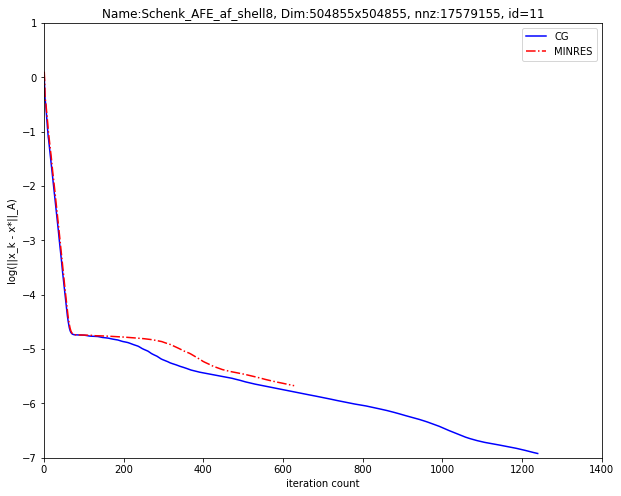

In [11]:
plot_A_norm(cg_errors_A_norm, minres_errors_A_norm)


Errors of minres: [array(3.55465549), array(2.3758469), array(1.99864087), array(1.81736861), array(1.49775847)]

Errors of minres: [array(6.88815193), array(4.69077574), array(2.36206006), array(2.00106524), array(1.81143755)]

Errors of minres: [0.83810272 0.67124467 0.37329094 0.30126125 0.25802337]


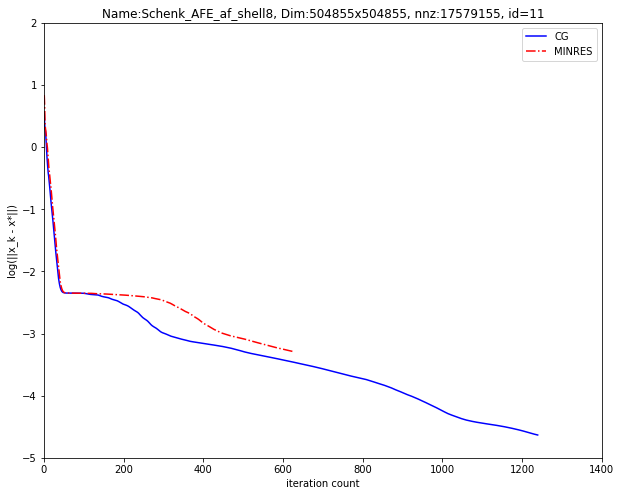

In [12]:
# Plot the log(||xk-x*||) errors

def plot_norm(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1, len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1, len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.set_ylabel('log(||x_k - x*||)')
    ax.set_title('Name:Schenk_AFE_af_shell8, Dim:504855x504855, nnz:17579155, id=11')

    # Set y-axis limits
    ax.set_xlim(0, 1400)
    ax.set_ylim(-5, 2)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()

# errors of log||xk - x* || in each iteration

# errors of cg
errors3_cg = [np.linalg.norm(xk - x_unique) for xk in xk_cg]
errors_norm3_cg = [np.array(err) for err in errors3_cg]

print('\nErrors of minres:', errors_norm3_cg[0:5])
cg_errors_norm3 = np.log10(errors_norm3_cg)



# errors of minres

errors3_minres = [np.linalg.norm(xk - x_unique) for xk in xk_minres]
errors_norm3_minres = [np.array(err) for err in errors3_minres]

print('\nErrors of minres:', errors_norm3_minres[0:5])
minres_errors_norm3 = np.log10(errors_norm3_minres)

print('\nErrors of minres:', minres_errors_norm3[0:5])


# plot
plot_norm(cg_errors_norm3, minres_errors_norm3)